In [1]:
import numpy as np
import typing as typ
import itertools as it
import matplotlib.pyplot as plt
from scipy.interpolate import interpn
import dolfin as dl

# Generate maze using recursive backtracker.

In [2]:
nx = 10
ny = 10
# box = [bmin[0],bmax[0]) x [bmin[0],bmax[1]) x ... x [bmin[0],bmax[d])
bmin = (0,0)
bmax = (nx,ny)


def in_box(
    inds: typ.Tuple[int,...], # len=d
) -> bool:
    return np.all(np.array(bmin) <= np.array(inds)) & np.all(np.array(inds) < np.array(bmax))
    
    
def neighbors(
    inds: typ.Tuple[int,...], # len=d
) -> typ.List[typ.Tuple[int,...]]: # list of neighbors inds
    d = len(inds)
    nn = [] # In 2D away from the boundary this will be [(i-1,j), (i+1,j), (i,j-1), (i,j+1)]
    for ii in range(d):
        inds_before = list(inds)
        inds_before[ii] -= 1
        inds_before = tuple(inds_before)
        if in_box(inds_before):
            nn.append(inds_before)
        
        inds_after = list(inds)
        inds_after[ii] += 1
        inds_after = tuple(inds_after)
        if in_box(inds_after):
            nn.append(inds_after)
    return nn

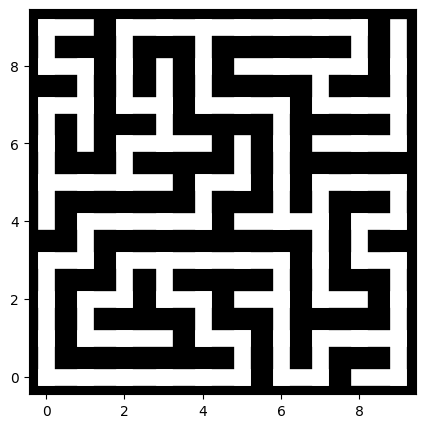

In [3]:
visited = np.zeros(bmax, dtype=bool)


def make_subtree(
    root_inds: typ.Tuple[int,...]
) -> typ.Tuple[
    typ.Tuple[int], # root_inds
    typ.List, # subtrees
]:
    visited[root_inds] = True
    subtrees = []
    nn = neighbors(root_inds)
    perm = list(np.random.permutation(len(nn)))
    for p in perm:
        neighbor_inds = nn[p]
        if not visited[neighbor_inds]:
            subtrees.append(make_subtree(neighbor_inds))
    return (root_inds, subtrees)


fig = plt.figure(figsize=(5,5))
plt.gca().set_facecolor('k')

def draw_2d_tree(
    T: typ.Tuple[
        typ.Tuple[int,...], # root_inds
        typ.List, # subtrees
    ],
):
    root_inds, subtrees = T
    assert(len(root_inds) == 2)
    for sub_T in subtrees:
        draw_2d_tree(sub_T)
        subtree_inds = sub_T[0]
        plt.plot([root_inds[0], subtree_inds[0]], [root_inds[1], subtree_inds[1]], 'w', linewidth=12)

T = make_subtree((5,6))
draw_2d_tree(T)

# Convert maze from tree structure to boolean array

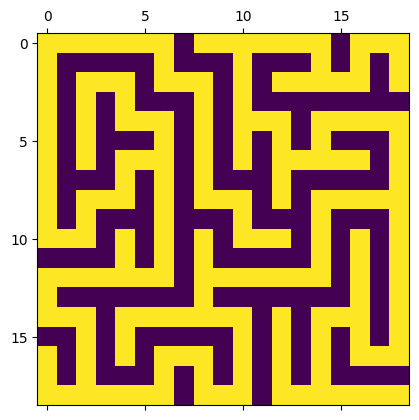

In [4]:
maze = np.zeros(tuple(2*np.array(bmax)-1), dtype=bool)


def carve_room(
    inds: typ.Tuple[int,...], # len=d
) -> None:
    maze[tuple(2*np.array(inds))] = True
    
    
def carve_passage(inds1, inds2):
    dim = np.argmax(np.abs(np.array(inds1) - np.array(inds2)))
    passage = 2*np.array(inds1)
    passage[dim] = inds1[dim] + inds2[dim]
    maze[tuple(passage)] = True
    
    
def carve_maze(
    T: typ.Tuple[
        typ.Tuple[int,...], # root_inds
        typ.List, # subtrees
    ],
):
    root_inds, subtrees = T
    carve_room(root_inds)
    for sub_T in subtrees:
        subtree_inds = sub_T[0]
        carve_passage(root_inds, subtree_inds)
        carve_maze(sub_T)

        
carve_maze(T)
plt.matshow(maze)

# Make function to evaluate maze value at points.

Maze now is defined in unit box

In [5]:
num_cells_1d = [2*s-1 for s in bmax]
hh_1d = [1.0 / nc for nc in num_cells_1d]
cell_centers_1d = [np.linspace(h/2.0, 1.0 - h/2.0, nc) for nc, h in zip(num_cells_1d, hh_1d)]
print('edge to first center:', cell_centers_1d[0][0])
print('first center to second center:', cell_centers_1d[0][1] - cell_centers_1d[0][0])
print('last center to edge:', 1.0 - cell_centers_1d[0][-1])

edge to first center: 0.02631578947368421
first center to second center: 0.05263157894736842
last center to edge: 0.02631578947368418


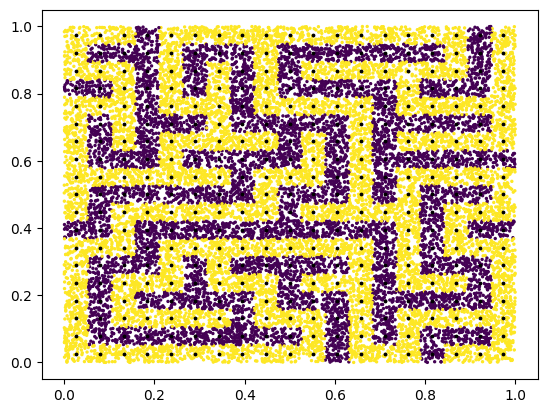

In [6]:
eval_min_point = (np.array(hh_1d) / 2.0 + 1e-7).reshape((1,-1))
eval_max_point = (1.0 - np.array(hh_1d) / 2.0 - 1e-7).reshape((1,-1))

def eval_maze_at_points(
    points: np.ndarray, # points to evaluate at. shape=(num_points, d)
):
    projected_points = np.maximum(eval_min_point, np.minimum(points, eval_max_point))
    return interpn(
        cell_centers_1d, maze, projected_points, 
        method='nearest', bounds_error=False, fill_value=1.0,
    )

pp = np.random.rand(20000,2)
mm = eval_maze_at_points(pp)

cell_centers_X, cell_centers_Y = np.meshgrid(cell_centers_1d[0], cell_centers_1d[1])

plt.scatter(pp[:,0], pp[:,1], c=mm, s=2)
plt.scatter(cell_centers_X, cell_centers_Y, c='k', s=3)

# Make maze into fenics function

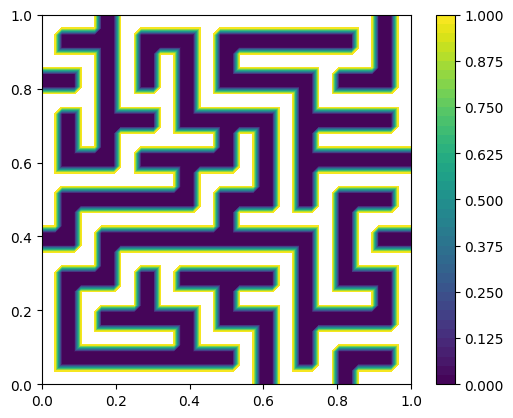

In [7]:
nx_mesh = 3*(2*nx-1)-1
ny_mesh = 3*(2*ny-1)-1

kappa_min = 1e-4

mesh = dl.UnitSquareMesh(nx_mesh, ny_mesh)
Vh = dl.FunctionSpace(mesh, 'CG', 1)
dof_coords = Vh.tabulate_dof_coordinates()

maze_vec = eval_maze_at_points(dof_coords)

kappa = dl.Function(Vh)
kappa.vector()[:] = kappa_min + maze_vec*(1.0 - kappa_min)
cm = dl.plot(kappa)
plt.colorbar(cm)

# Generate stiffness matrix and source RHS vector

In [8]:
u_trial = dl.TrialFunction(Vh)
v_test = dl.TestFunction(Vh)

stiffness_form = kappa * dl.inner(dl.grad(u_trial), dl.grad(v_test)) * dl.dx
K = dl.assemble(stiffness_form)

source_form = v_test * dl.Constant(0.0) * dl.dx
f = dl.assemble(source_form)

# Create boundary conditions, modify stiffness matrix and source vector

In [9]:
u_inflow = dl.Constant(1.0)
u_outflow = dl.Constant(0.0)

def inflow_boundary(x, on_boundary):
    return x[0] < hh_1d[0] and x[1] < hh_1d[1] and on_boundary

def outflow_boundary(x, on_boundary):
    return 1.0 - hh_1d[0] < x[0] and 1.0 - hh_1d[1] < x[1] and on_boundary

bc_in = dl.DirichletBC(Vh, u_inflow, inflow_boundary)
bc_out = dl.DirichletBC(Vh, u_outflow, outflow_boundary)

bc_in.apply(K, f)
bc_out.apply(K, f)

# Solve PDE

Text(0.5, 1.0, 'solution with walls zeroed out')

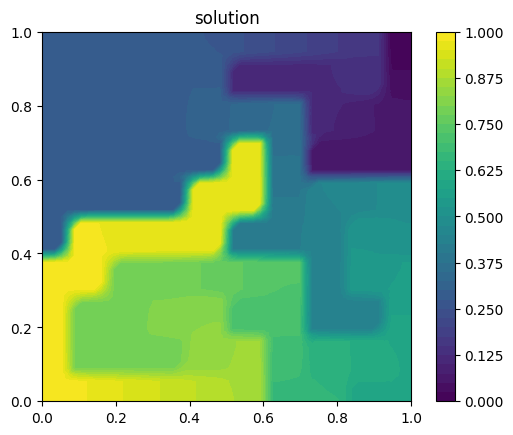

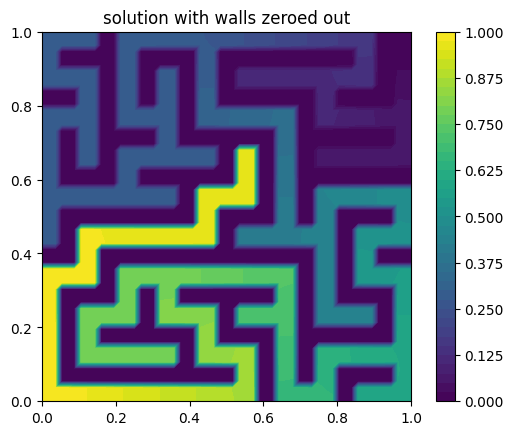

In [10]:
u = dl.Function(Vh)
dl.solve(K, u.vector(), f)

# plot solution
cm = dl.plot(u)
plt.colorbar(cm)
plt.title('solution')

# plot solution with maze_walls
plt.figure()
u_with_walls = dl.Function(Vh)
u_with_walls.vector()[:] = u.vector()[:] * maze_vec
cm = dl.plot(u_with_walls)
plt.colorbar(cm)
plt.title('solution with walls zeroed out')

Object cannot be plotted directly, projecting to piecewise linears.
Calling FFC just-in-time (JIT) compiler, this may take some time.


Text(0.5, 1.0, 'solved flux vector field')

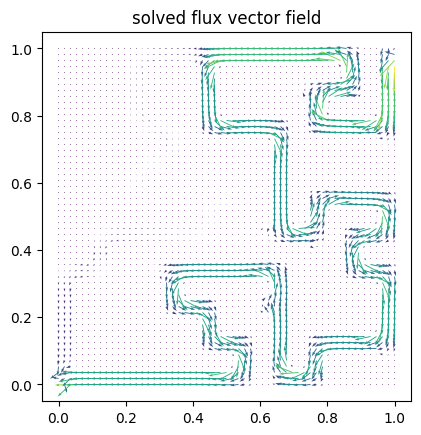

In [11]:
maze_func = dl.Function(Vh)
maze_func.vector()[:] = maze_vec

dl.plot(kappa * dl.grad(u))
plt.title('solved flux vector field')